# Training a Recurrent Neural Network with transfer learning and a language model

### Motivation

Word embeddings algorithms like word2vec and GloVe provide a mapping of words to a high-dimensional continuous vector space where different words with a similar meaning have a similar vector representation. These word embeddings, pre-trained on large amounts of unlabeled data, are used to initialize the first layer of a neural network called embedding layer, the rest of the model is then trained on data of a particular task. This kind of transfer learning in NLP problems is shallow as learning is transferred to only the first layer of the model, the rest of the network still needs to be trained from scratch. A model initialized with word embeddings needs to learn from scratch not only to disambiguate words, but also to derive meaning from a sequence of words. 

<img width='700' src='https://cdn-images-1.medium.com/max/800/0*Q7o7qvuJf7W6JNeY.png' />

A language model attempts to learn the structure of natural language through hierarchical representations, and thus contains both low-level features (word representations) and high-level features (semantic meaning). A key feature of language modelling is that it is generative, meaning that it aims to predict the next word given a previous sequence of words. It is able to do this because language models are typically trained on very large datasets in an unsupervised manner, and hence the model can “learn” the syntactic features of language in a much deeper way than word embeddings 

<img width='800' src='https://cdn-images-1.medium.com/max/2100/1*9J_7_aT_D7b-AcKtv5NPOQ.png' />

## About fast.ai

fast.ai is a Python library which works on top of PyTorch and it allows you to build complex Machine Learning models with few lines of code. It is intended to be use in teaching scenarios and it usually reduces the complexity of coding to focus on the Machine Learning concepts.

You can install fast.ai in Python using both Conda or Pip:

- **If using PIP**:
 pip install pytorch fastai

- **If using Conda**
 conda install -c pytorch -c fastai fastai pytorch

In [57]:
import fastai
from fastai import *
from fastai.text import *

## About the IMDB dataset

It contains 100k reviews on IMDB. 25k of them are labelled as positive and negative, another 25k are labeled for testing. The remaining 50k is an addional unlabelled data (we will find a use for it nonetheless). Since the dataset is big, let's start loading a sample. fast.ai already has a way to get a sample of this dataset, which is specified by URLs.IMDB_SAMPLE. Since the content is compressed (in tar format) we need to use the method untar_data to extract the content:

In [4]:
# Language model data
imdb_path = untar_data(URLs.IMDB_SAMPLE)
imdb_path.ls()

[PosixPath('/home/santiagxf/.fastai/data/imdb_sample/tmp'),
 PosixPath('/home/santiagxf/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/home/santiagxf/.fastai/data/imdb_sample/models')]

We see that the sample is specified in a csv file. We can load a csv file easily using the following method specifying the path where the data is and the name of the file.

In [6]:
data_lm = TextLMDataBunch.from_csv(imdb_path, 'texts.csv')

We can inspect the data loaded using the show_batch method which will pull the top 5 rows

In [9]:
data_lm.show_batch()

idx,text
0,"in the hunt for buffalo as well . xxmaj in his early scenes , xxmaj nolan was really doing an excellent take - off of xxmaj walter xxmaj xxunk in his xxmaj oscar - winning role in xxmaj the xxmaj treasure of the xxmaj xxunk xxmaj xxunk in 1948 . xxmaj note the appearance of xxmaj russ xxmaj xxunk in the film . xxmaj the following year xxmaj xxunk and"
1,"xxunk aggressive touch , xxmaj allen xxunk his heroine of his own presence , as well , killing off his character , the magician , leaving xxmaj xxunk xxmaj johansson all alone at the end of the film . \n\n a final note : at my screening , not a single audience member laughed at any point during the film . xxmaj always a bad sign when a film is"
2,"xxunk and xxmaj xxunk which was pretty funny . xxmaj he does n't do a good job here though as the story is a mess . xxmaj he also forgot to add jokes and a few other things that would have made this film work better . xxmaj the movie is also pretty long for a comedy . xxmaj okay , xxunk minutes is n't exactly long but it feels"
3,"during the ultimate show - down in the woods a total lack of xxunk , like a bunch of frightened xxunk , xxunk and shooting randomly around . \n\n xxmaj aaron , for some xxunk medical reason , feels like a wolf after the xxunk of the eyes . xxmaj why would that be ? ? ? xxmaj he suddenly sees xxunk of wandering wolves . xxmaj what is this"
4,"that i xxunk to see in films , but never do . xxmaj the cinematography was brilliant due to it 's simplicity and truly making the film seem ' xxmaj grim ' throughout - in terms of setting . xxmaj the writing was so well put together as well , whoever said this movie is n't as witty as xxmaj henry xxmaj fool needs to watch again and actually listen"


### What's happening behind the scenes?

The method is specific for text loading and **it does a bit more than loading the data.** The first step of processing text consists on spliting the raw sentences into words, or more exactly into tokens. The easiest way to do that would be to split the string on spaces, but...:
 - we need to take care of punctuation
 - some wors are contactions of two different words, like isn't or don't
 
The loading method is also doing the preprocessing for us:
- The s are grouped together in one token
- The contractions are separated
- Content has been lower cased
- there are several special tokens (all the ones that begins with xx) to replace unknown tokens or to introduce different text fields

### How the dictionary looks like?

The mapping from ids tokens is stored in the vocab attribute of our datasets, in a dictionary called itos (for int to string)

In [246]:
data_lm.train_ds.vocab.itos[:15]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',',
 '.',
 'and',
 'a',
 'of',
 'to']

Let's see how the underlying data is actually stored

In [12]:
data_lm.train_ds[0][0].data[:10]

array([   2,    4,  393,    4, 1992,  447, 1307,  394,   14,   42])

# Time for some action
Let's see how to create our classification model now. We are going to the the following:

- Load the dataset
- Create a language model that will encode the text into vectors with the help of transfer learning
- Create a classification model that will predict the sentiment of a review. The vector encoding of the inputs will be the one of the model we did before


## Loading the dataset

Now we are going to use the entire dataset for creating our model in a similar way we did before

In [58]:
imdb_path = untar_data(URLs.IMDB)
imdb_path.ls()

[PosixPath('/home/santiagxf/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/santiagxf/.fastai/data/imdb/test'),
 PosixPath('/home/santiagxf/.fastai/data/imdb/train'),
 PosixPath('/home/santiagxf/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/santiagxf/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/santiagxf/.fastai/data/imdb/unsup'),
 PosixPath('/home/santiagxf/.fastai/data/imdb/README'),
 PosixPath('/home/santiagxf/.fastai/data/imdb/models')]

In this case we can't use the load csv method because we are going to load both the train and test folders. **Can you guess why?**

In [59]:
data_lm = (TextList.from_folder(imdb_path)
          .filter_by_folder(include=['train', 'test'])
          .random_split_by_pct(0.1)
          .label_for_lm()
          .databunch())

data_lm.save('lm_dictionary')

#if training is taking to much time for you, you may need to get a GPU to speed up the process. Uncomment the following two lines to use a smaller dataset you can train in minutes.
# imdb_path = untar_data(URLs.IMDB_SAMPLE)
#data_lm = TextLMDataBunch.from_csv(imdb_path, 'texts.csv')

The labels of each review is the review itself, because what we are modeling at this point is the language. So we don't need to make a distinction between test and training. It's all data and remember that the more data we have the better our model will be. After than we are setting aside 10% of the data as validation for our language model.

Remember that the loading method will do all the text processing for us. No need to do any extra step here.

In [70]:
data_lm = TextLMDataBunch.load(imdb_path, 'lm_dictionary')

## Training a language model with transfer learning

We are not going to train a classification model from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (WIKI103). That model has been trained to guess the next word after a sentence. The models uses a recurrent neural network (a recurrent structure) that get's updated each time it sees a new word so it can model sequences. We want to use this model to understand the structure of the English language which in turn can help us in our sentiment analysis.

We have to use a special kind of learner for the language model (because the labels are the text itself!). The learner will be a recurrent neural network. The method needs the data for training, the pretrained model we want to use (in this case WT103) and the amount of dropout we want to use. Dropout is a technique in Neural Networks that allows us to introduce regularization and avoid overfitting. We won't get into the details about how they work now but you are welcome to review the concept.

In [74]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)

#### Have you heard about hyperparameters?
It is a common problem in Machine Learning and it usually requires a lot of experience to know what to use. fast.ai have a method to find this parameters and that method is lr_find(). The theory behind it is a bit extense, but basically the idea is to start with a low learning rate and start to increase it step by step until the loss of the model starts to explote. This method will do that for us

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


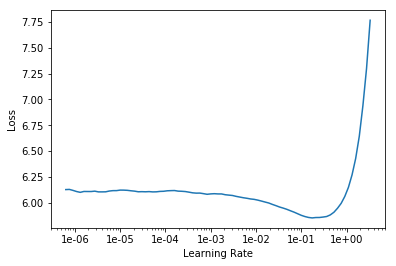

In [13]:
learn.recorder.plot()

Once we now the learning rate, it's time to start the training. In fast.ai, the trainig is usually done using a method called fit_one_cycle by specifying the number of epochs, the learning rate and the momentum. If you are not familiar with this concepts, don't worry. Those are specific terms when training neural networks using a well know method called stochastic gradient descent (SGD).

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.338286,4.190292,0.276165


To finalize the training, we typically unfreeze the last layer and then fine-tune the model. This is a practice in Transfer Learning where the idea here is that the firsts layers will contain the structure and knowledge of the english language in general, but the last layer will have knowledge specific of our data set. In this way we retain the generalization learned from the english language all combined with the specific aspects of our dataset. 

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.990510,3.935088,0.303298


What do you think? Is it a good model? what does the 0.3 means?

Since training maybe time consuming... it's always a good idea to save the trained model to use it later.

In [ ]:
learn.save_encoder('lm_encoder')

#### How good is our language model?
We can check that trying to predicts the next words after a sentence. We are fist loading the encoder just in case we don't want to do all the training again. we just want to test it

In [75]:
learn.load_encoder('lm_encoder')

In [79]:
learn.predict("This is a review about", n_words=10)

'This is a review about the topic of the dream with the main character .'

**Note**: This is shown just for the sake of this demostration. There are better ways to create a system that predicts the next word from a sentence

## Training a classifier

Now it's time to create our classifier wich will use our language model to classify the sentiment of the review. To do that, we need to load the dataset again but in a different way. The reason for that is that now the label of our dataset is not the text itself, but the Sentiment of the review. However, it is important to pay attention that when loading the data we are specifying a parameter called vocab which value is assigned to data_lm.vocab. The reason for that is that we want to ensure that both datasets will use the same encoding for the same words. For that to happen the vocabulary has to remain the same. In this way, if the word "bank" is mapped to [1,0,0], it will remain mapped to that number in this dataset. Pay also attention that now we are splitting the dataset in 2, for training and testing

In [ ]:
data_clas = (TextList.from_folder(imdb_path, vocab=data_lm.vocab)
             .split_by_folder(valid='test')
             .label_from_folder(classes=['neg','pos'])
             .databunch(bs=42)

# we save the dictionary to load it later.
data_clas.save('clas_dictionary')
             
# if training is taking to much time for you, you may need to get a GPU to speed up the process. Uncomment the following line to use a smaller dataset you can train in minutes.
#data_clas = (TextList.from_csv(imdb_path, 'texts.csv', cols='text', vocab=data_lm.vocab)
#                  .split_from_df(col='is_valid')
#                  .label_from_df(cols='label')
#                  .databunch())

If we don't want to preprocess all the data again, we can load the dictionary we are working with from the one we just saved

In [80]:
data_clas = TextClasDataBunch.load(imdb_path, 'clas_dictionary')

In [91]:
data_clas.show_batch()

text,target
xxbos in fact it s hard to remember that the part of ray charles is being acted and not played by the man xxunk ray charles is xxunk ray charles life xxunk excellent xxunk xxunk for the film which xxunk well beyond being just another movie about a xxunk hitchcock is a great director xxunk i mostly find his films a xxunk waste of time to watch xxunk hitchcock pretty,0
xxbos the xxunk of this film is easily the most xxunk xxunk in the history of cinema i can think of no other film where xxunk xxunk important xxunk every other minute in other xxunk the xxunk level of this film is enough to easily xxunk a xxunk other films how can anyone in their right mind xxunk for anything more from a movie than this it s quite simply,0
xxbos with great sound effects and xxunk special effects i can t recommend this movie enough xxunk me a xxunk but i think this is one of the best movies ever great character actors xxunk xxunk and xxunk xxunk hour minutes of xxunk xxunk xxunk and horrible acting a mess of a script and a xxunk feeling of good xxunk what were they xxunk lots of holes in the script,1
xxbos i love it the ending is so so perfect you ll xxunk a xxunk i am so xxunk after seeing a movie like this i will never xxunk it now it is not just a cult it is a cult classic which has more depth and character than the man xxunk it the xxunk xxunk are as xxunk and as xxunk as the dialogue this movie is terrible the,0
xxbos you ll love it this movie is bad so bad the film is way too long this is definitely one of the bad xxunk the movie i xxunk was a great quality film for it s age john xxunk did an incredible job for being so young in the movie xxunk his on screen xxunk xxunk thought even though there were other xxunk actors on the screen with him,1


### The model architecture

As we did before, we need to train our classifier. fast.ai has this implementation of text_classifier_learner which uses a recurrent neural network for classification. The basic architecture of a RNN looks like the following.

<img width='600px' src='https://cdn-images-1.medium.com/max/1200/1*LhnaHTLBa_R53MpuZza23A.png' />

In [83]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.5)

Do you remember that we saved our encoder some lines above? So it's time to use it! The encoder will be used to map the word to specific cordinated in the feature space

In [85]:
learn_clas.load_encoder('lm_encoder')

Let's find the learning rate we have to use

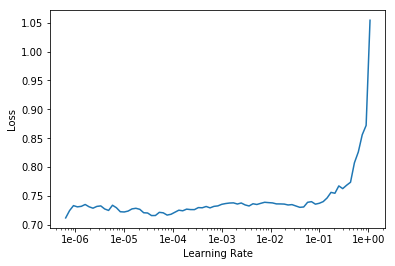

In [107]:
learn_clas.freeze()
learn_clas.lr_find()
learn_clas.recorder.plot()

Time for training, as usual

In [264]:
learn_clas.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.419972,0.301174,0.92688


We save our classifier to use it later so we can test it without training

In [ ]:
learn_clas.save('lm_classifier')

#### Let's try it:

We first load the model we previously saved

In [87]:
learn_clas = learn_clas.load('lm_classifier')

We can use the predict method to get the scoring of the sentiment

In [92]:
learn_clas.predict("Great movie although there is room to improvement")

(Category pos, tensor(1), tensor([0.2474, 0.7526]))